In [18]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [19]:
from keras import regularizers

In [20]:
import os

In [21]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import librosa
from librosa import display

data, sampling_rate = librosa.load('/Users/abhay/Python/sentiment-predictor-for-stress-detection/Audio_Speech_Actors_01-24/Actor_01/03-01-05-02-01-02-01.wav')



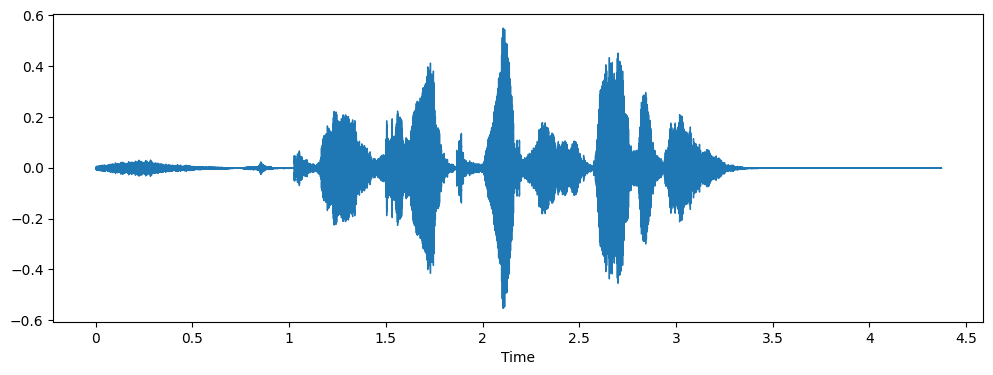

In [22]:
%matplotlib inline
import os
import pandas as pd
import glob 
import librosa.display

plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)

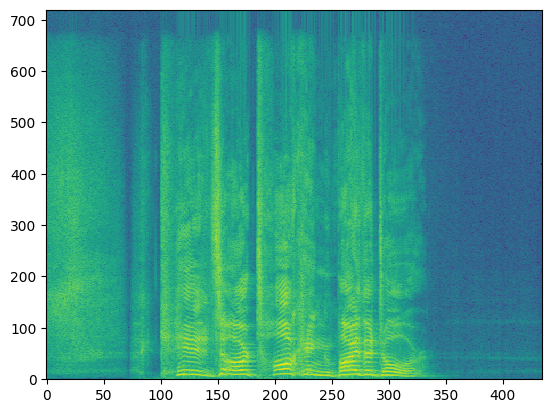

In [23]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('/Users/abhay/Python/sentiment-predictor-for-stress-detection/Audio_Speech_Actors_01-24/Actor_01/03-01-05-02-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [24]:
import time
import librosa
import librosa.feature

path = '/Users/abhay/Python/sentiment-predictor-for-stress-detection/Audio_Speech_Actors_01-24/Actor_01'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        #, res_type='kaiser_fast'
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 0.7242920398712158 seconds ---


In [25]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [26]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((60, 40), (60,))

In [27]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/Users/abhay/Python/sentiment-predictor-for-stress-detection/Saved_Models'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))


In [28]:
# Loading saved models

X = joblib.load('/Users/abhay/Python/sentiment-predictor-for-stress-detection/Saved_Models/X.joblib')
y = joblib.load('/Users/abhay/Python/sentiment-predictor-for-stress-detection/Saved_Models/y.joblib')

## Decision Tree Model

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
dtree = DecisionTreeClassifier()

In [32]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [33]:
predictions = dtree.predict(X_test)

In [34]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           2       0.25      0.50      0.33         2
           3       0.00      0.00      0.00         4
           4       1.00      0.67      0.80         3
           5       0.67      0.50      0.57         4
           6       0.00      0.00      0.00         2
           7       0.14      0.50      0.22         2

    accuracy                           0.39        18
   macro avg       0.37      0.45      0.37        18
weighted avg       0.39      0.39      0.36        18



## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier


In [36]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [37]:
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [38]:
predictions = rforest.predict(X_test)

In [39]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.20      0.50      0.29         2
           3       0.00      0.00      0.00         4
           4       1.00      0.67      0.80         3
           5       1.00      0.25      0.40         4
           6       0.50      0.50      0.50         2
           7       0.33      0.50      0.40         2

    accuracy                           0.33        18
   macro avg       0.38      0.30      0.30        18
weighted avg       0.50      0.33      0.35        18



In [40]:
##Neural Network
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [41]:
x_traincnn.shape, x_testcnn.shape

((42, 40, 1), (18, 40, 1))

In [42]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import backend as k
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
 

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, weight_decay=0.0)

# decay -> weight_decay

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 128)           768       
                                                                 
 activation (Activation)     (None, 40, 128)           0         
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 128)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_1 (Activation)   (None, 5, 128)            0         
                                                        

In [44]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
3/3 [==============================] - 0s 38ms/step - loss: 18.1490 - accuracy: 0.0952 - val_loss: 22.6920 - val_accuracy: 0.0556
Epoch 2/1000
3/3 [==============================] - 0s 6ms/step - loss: 20.9071 - accuracy: 0.0476 - val_loss: 8.5539 - val_accuracy: 0.1111
Epoch 3/1000
3/3 [==============================] - 0s 6ms/step - loss: 11.0229 - accuracy: 0.1905 - val_loss: 10.8179 - val_accuracy: 0.1111
Epoch 4/1000
3/3 [==============================] - 0s 6ms/step - loss: 11.6246 - accuracy: 0.1667 - val_loss: 11.2997 - val_accuracy: 0.1111
Epoch 5/1000
3/3 [==============================] - 0s 6ms/step - loss: 11.4102 - accuracy: 0.1429 - val_loss: 10.7654 - val_accuracy: 0.1111
Epoch 6/1000
3/3 [==============================] - 0s 6ms/step - loss: 8.7295 - accuracy: 0.0714 - val_loss: 7.3782 - val_accuracy: 0.1111
Epoch 7/1000
3/3 [==============================] - 0s 6ms/step - loss: 6.9005 - accuracy: 0.0714 - val_loss: 5.3223 - val_accuracy: 0.1667
Epoch 8/10

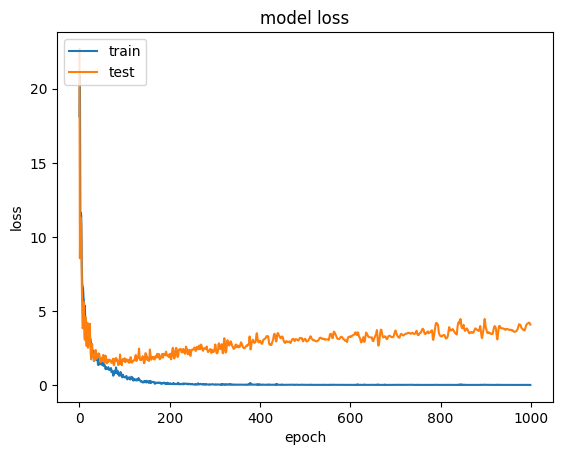

In [46]:
# Loss 
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

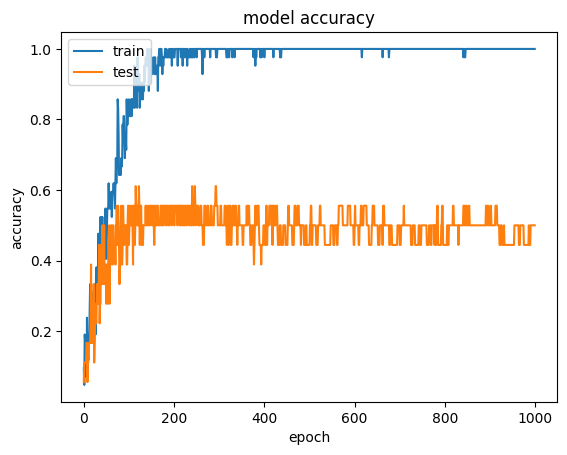

In [47]:
## This is for Accuracy
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
#predictions = model.predict_classes(x_testcnn)
predict_x=model.predict(x_testcnn) 
predictions=np.argmax(predict_x,axis=1)

1/1 [==============================] - 0s 40ms/step


In [49]:
predictions

array([7, 7, 1, 5, 1, 6, 6, 7, 7, 7, 2, 4, 2, 1, 2, 2, 2, 3])

In [50]:
y_test

array([3, 7, 5, 5, 0, 6, 6, 7, 4, 3, 5, 4, 4, 5, 2, 3, 2, 3])

In [51]:
new_Ytest = y_test.astype(int)

In [52]:
new_Ytest

array([3, 7, 5, 5, 0, 6, 6, 7, 4, 3, 5, 4, 4, 5, 2, 3, 2, 3])

In [53]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.40      1.00      0.57         2
           3       1.00      0.25      0.40         4
           4       1.00      0.33      0.50         3
           5       1.00      0.25      0.40         4
           6       1.00      1.00      1.00         2
           7       0.40      1.00      0.57         2

    accuracy                           0.50        18
   macro avg       0.60      0.48      0.43        18
weighted avg       0.81      0.50      0.50        18



In [54]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0]
 [0 0 1 1 0 0 0 2]
 [0 0 1 0 1 0 0 1]
 [0 2 1 0 0 1 0 0]
 [0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 2]]


In [55]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/Users/abhay/Python/sentiment-predictor-for-stress-detection/Saved_Models'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/abhay/Python/sentiment-predictor-for-stress-detection/Saved_Models/Emotion_Voice_Detection_Model.h5 


In [56]:
from tensorflow import keras

from tensorflow.keras.models import load_model

from tensorflow.keras.utils import CustomObjectScope

from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):

    loaded_model = load_model('/Users/abhay/Python/sentiment-predictor-for-stress-detection/Saved_Models/Emotion_Voice_Detection_Model.h5')
    loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 128)           768       
                                                                 
 activation (Activation)     (None, 40, 128)           0         
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 128)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_1 (Activation)   (None, 5, 128)            0         
                                                        

In [57]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1/1 [==============================] - 0s 68ms/step - loss: 4.0741 - accuracy: 0.5000
Restored model, accuracy: 50.00%
